# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 37

**Author 1 (sciper):** Elias De Smijter (366670)  
**Author 2 (sciper):** Félicie Alice Agnès Marie Giraud-Sauveur (284220)   
**Author 3 (sciper):** Cyril Felix Monette (299554) 

**Release date:** 19.04.2023  
**Due date:** 05.05.2023 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

--
## 0. Setup

In [291]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this lab, we will use PyTorch. If you are not familiar with this library, [here](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) is a quick tutorial of the basics.

In [292]:
import platform
print(platform.system())
if platform.system() == "Darwin":
    %pip install torch==1.8.1 torchvision==0.9.1
else:
    %pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Darwin
Note: you may need to restart the kernel to use updated packages.


In [293]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1 - Out-of-Distribution detection in colorectal cancer histology (12 points)

Colorectal cancer is one of the most widespread cancers for men and women. Diagnosis complemented with prognostic and predictive biomarker information is essential for patient monitoring and applying personalized treatments. A critical marker is the tumor/stroma ratio in unhealthy tissues sampled from the colon. The higher the ratio, the more invasive the cancer is. The degree of invasion is tightly linked to patient survial probability.

To measure the ratio, a pathologist needs to analyze the unhealthy tissue under a microscope and estimate it from a look. As the number of samples to analyze is huge and estimations are only sometimes precise, automatic recognition of the different tissue types in histological images has become essential. Such an automatic process requires the development of a multi-class classifier to identify the numerous tissues. As shown below, they are usually 8 tissue types to categorize: TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE and EMPTY (background).

<br />
<br />
<figure>
    <img src="../data/lab-03-data/part1/kather16.svg" width="1100">
    <center>
    <figcaption>Fig1: Collection of tissue types in colorectal cancer histology (Kather-16)</figcaption>
    </center>
</figure>
<br />
<br />


Up to this day, state-of-the-art methods use deep-learning-based supervised learning methods. A downfall of such an approach is the necessity to access a well-annotated training dataset. In histology, annotating data is difficult. It is time-consuming and requires the expertise of pathologists. Moreover, the annotator must label every tissue type while only two (TUMOR and STROMA) are interesting. 


Consequently, we propose another approach. In order to make the annotation task less tedious, we ask the annotator to label only the tissues of interest and dump the others. Then, we must train a binary classifier to automatically recognize these tissues at test time. In this part, you will implement the proposed approach.

### 1.1 Binary classifier with Mahalanobis distance (3 points)

Based on the abovementioned process, your task is to build a model that recognizes TUMOR (Label 0) and STROMA (Label 1) tissue types. Your model will be supervised by a training dataset containing TUMOR and STROMA annotations; note that all other tissues have been dropped.
We will not ask you to train a deep-learning-based binary classifier from scratch. Instead, we provide excellent features (descriptors) of the images we extracted from a visual foundation model. (Note: As the nature of the foundation model is not part of this lecture, feel free to ask TAs if you are curious).

Run the cell below to extract the provided train and test dataset. Each image is represented by a 768-d feature vector extracted from a visual foundation model. The train and test datasets contain feature vectors of 878 and 186 images respectively.

In [294]:
import torch 

# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

**Task 1 (2.5 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using minimum Mahalanobis distance.

*Note:* You are not allowed to use any prebuilt Mahalanobis distance function. Additionally, ```torch.cov``` is not defined to compute the covariance matrix. You can use ```sklearn.covariance.LedoitWolf``` instead.

In [295]:
from sklearn.covariance import LedoitWolf
import scipy as sp
import numpy as np

### Task 1

# Function to compute Mahalanobis Distance
def mahalanobis(x, data):
    """
    Computes the Mahalanobis Distance between each row of x and the data.
    Mahalanobis distance D : D^2 = (x-m)^T * C^(-1) * (x-m)
    x    : vector or matrix of data with p columns
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed
    """
    
    # Compute (x – mean(data))
    x_minus_mu = x - torch.mean(data)
    
    # Compute inverse of covariance of x
    cov = LedoitWolf().fit(data).covariance_
    inv_covmat = sp.linalg.inv(cov)
    
    # Compute Mahalanobis distance
    mahal = np.dot(np.dot(x_minus_mu, inv_covmat), x_minus_mu.T)**(1/2)
    
    return mahal.diagonal()


# Build the Mahalanobis Binary Classifier
class MahalanobisBinaryClassifier():
    def __init__(self, train_features, train_labels):
        
        # Split the training data as pos and neg
        self.stroma_features = train_features[train_labels==1, :]
        self.tumor_features = train_features[train_labels==0, :]

    def predict_proba(self, test_features):
        dists = list(zip(mahalanobis(test_features, self.stroma_features), mahalanobis(test_features, self.tumor_features)))
        probs = np.array([(stromaDist/(stromaDist+tumorDist), tumorDist/(stromaDist+tumorDist)) for stromaDist, tumorDist in dists])
        return probs

    def predict(self, test_features):
        return np.array([np.argmax(row) for row in self.predict_proba(test_features)])


# Apply the MahalanobisBinaryClassifier
clf = MahalanobisBinaryClassifier(train_features, train_labels)        
pred_probs = clf.predict_proba(test_features)
pred_class = clf.predict(test_features)

**Task 2 (0.5 points)** Compute the accuracy of your predictions with the test labels (```test_labels```).

In [296]:
from sklearn.metrics import accuracy_score

### Task 2

# Compute accuracy between predictions and the test labels
print('Accuracy Score: {:.2f}'.format(accuracy_score(test_labels, pred_class)))

Accuracy Score: 0.67


### 1.2 Out-of-Distribution detection with Mahalanobis distance (3 points)

You will note that the test you run above is not really realistic. Like the training set, it contains only the TUMOR and STROMA tissue types. Nevertheless, at test time, the other tissues (Label -1) are also present and cannot be filtered by hand. Moreover, they cannot be recognized by the model as they are out of the training distribution (It is the consequence of the laziness of the annotators ;)). For this reason, it is essential to filter them out. This task is called Out-of-Distribution (OoD) detection. 

A simple way to do OoD detection is to compute for every test example an OoD-ness score which should be low for In-Distribution (ID) examples and high for OoDs. Then we define a threshold from which every example with an OoD-ness lying above is discarded, and those lying below are forwarded to the model for prediction. An example of OoD-ness score is the minimum Mahalanobis distance.

Run the cell below to load a new test set containing OoD examples. It has 186 ID and 558 OoD examples.

In [297]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

test_features_w_ood.shape

torch.Size([744, 768])

**Task 1 (0.5 point)** Why do you think the minimum Mahalanobis distance is a good OoD-ness score?

**Answer: Looking at Mahalanobis distance of a sample from every available class (in our case 2 classes) enables to look at the similarity of the sample to the classes. OoD samples are not similar to any class and will thus have high distances to all of them, which leads to a high minimum Mahalanobis distance.**

**Task 2 (0.5 point)** Compute the minimum Mahalanobis distance for every test examples in ```test_features_w_ood``` with respect to the training features (```train_features```).

In [298]:
### Task 2

# Compute the minimum Mahalanobis distance for every test examples in test_features_w_ood with respect to the training features (train_features)
stroma_features = train_features[train_labels==1, :]
tumor_features = train_features[train_labels==0, :]
min_mahalanobis_ood = np.array([min(dist) for dist in zip(mahalanobis(test_features_w_ood, stroma_features), mahalanobis(test_features_w_ood, tumor_features))])

**Task 3 (0.5 point)** Plot a histogram to show the difference between the Mahalanobis distance of TUMOR, STROMA and OoD tissue types and comment on what you observe.

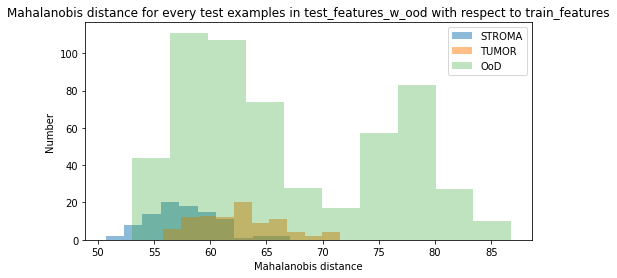

In [299]:
import matplotlib.pyplot as plt

### Task 3

# Histogram to show the difference between the Mahalanobis distance of TUMOR, STROMA and OoD tissue types
plt.figure(figsize=(8,4))
plt.hist(min_mahalanobis_ood[test_labels_w_ood==0], alpha=0.5, label='STROMA')
plt.hist(min_mahalanobis_ood[test_labels_w_ood==1], alpha=0.5, label='TUMOR')
plt.hist(min_mahalanobis_ood[test_labels_w_ood==-1], alpha=0.3, label='OoD')
plt.legend(loc='upper right')
plt.xlabel("Mahalanobis distance")
plt.ylabel("Number")
plt.title("Mahalanobis distance for every test examples in test_features_w_ood with respect to train_features")
plt.show()

**Observations: A large part of the Out of Distribution samples are very close (following an mahalanobis distance) to classes' average position. This means it is almost impossible to use mahalanobis distance to filter out the Out of Distribution samples from the data.**

**Task 4 (1 point)** Find a threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out?

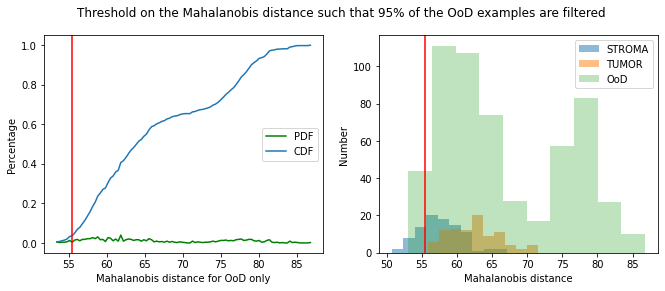

The threshold is: 55.407.
It filters: 96.42% of OoD data, 77.42% of STROMA data, and 100.00% of TUMOR data.


In [300]:
### Task 4

# Find the threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out

    # Getting data of the histogram for OoD examples
count, bins_count = np.histogram(min_mahalanobis_ood[test_labels_w_ood==-1], bins=100)
  
    # Finding the PDF of the histogram using count values
pdf = count / sum(count)
  
    # Using numpy np.cumsum to calculate the CDF
cdf = np.cumsum(pdf)

    # Define the threshold
threshold = bins_count[1:][cdf<=0.05][-1]
  
    # Plotting PDF and CDF with the threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
ax1.plot(bins_count[1:], pdf, color="green", label="PDF")
ax1.plot(bins_count[1:], cdf, label="CDF")
ax1.axvline(x=threshold, color = 'red')
ax1.legend()
ax1.set(xlabel='Mahalanobis distance for OoD only', ylabel="Percentage")

    # Plotting distributions with the threshold
ax2.hist(min_mahalanobis_ood[test_labels_w_ood==0], alpha=0.5, label='STROMA')
ax2.hist(min_mahalanobis_ood[test_labels_w_ood==1], alpha=0.5, label='TUMOR')
ax2.hist(min_mahalanobis_ood[test_labels_w_ood==-1], alpha=0.3, label='OoD')
ax2.legend(loc='upper right')
ax2.axvline(x=threshold, color = 'red')
ax2.set(xlabel='Mahalanobis distance', ylabel="Number")

fig.suptitle("Threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered")
plt.show()

    # Print results
print("The threshold is: {:.3f}.".format(threshold))

min_mahalanobis_ood_OoD = min_mahalanobis_ood[test_labels_w_ood==-1]
min_mahalanobis_ood_Stroma = min_mahalanobis_ood[test_labels_w_ood==0]
min_mahalanobis_ood_Tumor = min_mahalanobis_ood[test_labels_w_ood==1]

percent_filtered_Ood = len(min_mahalanobis_ood_OoD[min_mahalanobis_ood_OoD>threshold]) / len(min_mahalanobis_ood_OoD)
percent_filtered_Stroma = len(min_mahalanobis_ood_Stroma[min_mahalanobis_ood_Stroma>threshold]) / len(min_mahalanobis_ood_Stroma)
percent_filtered_Tumor = len(min_mahalanobis_ood_Tumor[min_mahalanobis_ood_Tumor>threshold]) / len(min_mahalanobis_ood_Tumor)

print("It filters: {:.2f}% of OoD data, {:.2f}% of STROMA data, and {:.2f}% of TUMOR data.".format(100*percent_filtered_Ood, 100*percent_filtered_Stroma, 100*percent_filtered_Tumor))

**Task 5 (0.5 point)** Assign prediction -1 to filtered out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```). Is it satisfactory?

In [301]:
### Task 5
from sklearn.metrics import confusion_matrix


# Apply the MahalanobisBinaryClassifier to test_features_w_ood
clf = MahalanobisBinaryClassifier(train_features, train_labels)        
pred_class_ood = clf.predict(test_features_w_ood)

# Assign prediction -1 to filtered out examples
pred_class_ood[min_mahalanobis_ood>threshold] = -1

# Compute accuracy between predictions and the test labels
print('Accuracy Score: {:.2f}%'.format(100*accuracy_score(test_labels_w_ood, pred_class_ood)))

# Compute the accuracy for the different sub-classes
#G et the confusion matrix
cm = confusion_matrix(test_labels_w_ood, pred_class_ood)
#array([[1, 0, 0],
#       [1, 0, 0],
#       [0, 1, 2]])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#array([[1.        , 0.        , 0.        ],
#       [1.        , 0.        , 0.        ],
#       [0.        , 0.33333333, 0.66666667]])

class_accuracies=cm.diagonal()
# array([1.        , 0.        , 0.66666667])

ood_accuracy=class_accuracies[0]
stroma_accuracy=class_accuracies[1]
tumor_accuracy=class_accuracies[2]

print(f'The accuracy for OoD samples: {ood_accuracy*100:.2f}% | for stroma samples: {stroma_accuracy*100:.2f}% | for tumor samples: {tumor_accuracy*100:.2f}%')

Accuracy Score: 75.13%
The accuracy for OoD samples: 96.42% | for stroma samples: 22.58% | for tumor samples: 0.00%


**This way of filtering is not relevant because the filter removes all data about the tumor. The general accuracy is high just by the fact that we have a lot of Out of Distribution samples, but this does not mean that the tumor versus stroma prediction is good.**

### 1.3 Out-of-distribution detection with k-NN classifier (6 points)

The visual foundation models are known to be very good k-NN classifiers. It motivates us to implement a k-NN classifier to recognize TUMOR and STROMA. Moreover, k-NN distance is a good OoD-ness score and suits our task.

**Task 1 (2 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using a k-NN classifier. Then report the accuracy of your predictions with the test labels (```test_labels```).

*Note:* The choice of `k` is up to you.

In [302]:
import sklearn.neighbors

### Task 1

k = 7

# k-NN classifier using euclidean distance
classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, metric='euclidean')
classifier.fit(train_features, train_labels)

# Classify the test features (test_features) using the k-NN classifier
predictions = classifier.predict(test_features)

# Accuracy between predictions and test labels
print('Accuracy Score: {:.2f}'.format(accuracy_score(test_labels, predictions)))

Accuracy Score: 0.99


**Task 2 (2 points)** Perform OoD detection on the test features (```test_features_w_ood```) using a k-NN distance based OoD-ness score. Find a threshold on your OoD-ness score such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out? Finally, assign prediction -1 to filter out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```).

*Note:* The OoD-ness is based on the distance to the k-nearest neighbors. The formulation is up to you. You have to justify your choice.

In [303]:
### Task 2
print('The OoD-ness score is the mean of the distances to the k-nearest neighbors.')

distances, _ = classifier.kneighbors(test_features_w_ood)
OoD_ness_scores = np.mean(distances, axis=1)

scores_for_ood = OoD_ness_scores[test_labels_w_ood==-1]
scores_for_tumor = OoD_ness_scores[test_labels_w_ood==0]
scores_for_stroma = OoD_ness_scores[test_labels_w_ood==1]

scores_for_ood_sorted = np.sort(scores_for_ood)
threshold = scores_for_ood_sorted[int(0.05*len(scores_for_ood))]
print(f'The threshold is: {threshold:.2f}')

percent_filtered_Ood = np.sum(scores_for_ood>threshold) / np.sum(test_labels_w_ood==-1)
percent_filtered_Stroma = np.sum(scores_for_stroma>threshold) / np.sum(test_labels_w_ood==0)
percent_filtered_Tumor = np.sum(scores_for_tumor>threshold) / np.sum(test_labels_w_ood==1)
print("It filters: {:.2f}% of OoD data, {:.2f}% of STROMA data, and {:.2f}% of TUMOR data.".format(percent_filtered_Ood*100, percent_filtered_Stroma*100, percent_filtered_Tumor*100))

predictions = classifier.predict(test_features_w_ood)
predictions[OoD_ness_scores>threshold] = -1
print(f'\nThe total accuracy is: {accuracy_score(test_labels_w_ood, predictions)*100:.2f}%')

# Compute the accuracy for the different sub-classes
#G et the confusion matrix
cm = confusion_matrix(test_labels_w_ood, predictions)
#array([[1, 0, 0],
#       [1, 0, 0],
#       [0, 1, 2]])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#array([[1.        , 0.        , 0.        ],
#       [1.        , 0.        , 0.        ],
#       [0.        , 0.33333333, 0.66666667]])

class_accuracies=cm.diagonal()
# array([1.        , 0.        , 0.66666667])

ood_accuracy=class_accuracies[0]
stroma_accuracy=class_accuracies[1]
tumor_accuracy=class_accuracies[2]

print(f'The accuracy for OoD samples: {ood_accuracy*100:.2f}% | for stroma samples: {stroma_accuracy*100:.2f}% | for tumor samples: {tumor_accuracy*100:.2f}%')

The OoD-ness score is the mean of the distances to the k-nearest neighbors.
The threshold is: 44.35
It filters: 94.98% of OoD data, 48.39% of STROMA data, and 69.89% of TUMOR data.

The total accuracy is: 81.45%
The accuracy for OoD samples: 94.98% | for stroma samples: 30.11% | for tumor samples: 51.61%


**Here we used the mean distance to the k nearest neighbours as OoD-ness score. Indeed, taking the minimum distance would in fact be equivalent to classifying the sample in the nearest training sample's class. Looking at the mean distance allows to see if the sample is generally close to samples in the training set or further away.**

**Task 3 (1 point)** Is k-NN better than Mahalanobis distance ? Make an hypothesis for the reasons.

**Answer: It works better than Malanobis distance filtering, perhaps because it takes multiple training samples into account rather than solely classes' mean position when filtering OoD samples.**

**Task 4 (1 point)** Do you think we can suggest the approach presented in this exercise to compute TUMOR/STROMA ratio automatically ? Justify your thoughs. If not, suggest at least two ideas to improve it.

*Note:* Annotating all the training dataset is not an option.

**Answer: Based on the accuracies for stroma and samples (which takes into account false positives and false negatives), it is not sufficient to be confident in the classification. Based on the number of features, it would be worth looking at other ways to find relevent features to classify on. Indeed, the number of features is in the same order of magnitude as the number of training samples, and lowering the number of features would enable to avoid the curse of dimensionality and have more accurate classification. Moreover, playing aroung with different ways of computing the OoD-ness scores from the kNN distances might yield better accuracies.**

---

## Part 2 (12 points)
In this part, we aim to classify cervical cells resulting from Pap smear tests. To that end we'll be using a publicly available cell dataset: Sipakmed (https://www.cs.uoi.gr/~marina/sipakmed.html). The dataset is composed of 4049 images of isolated cells cropped from 966 cluster cell images of Pap smear slides. Each cell in the dataset has been categorized in either of the following categories: 

    - Superficial-Intermediate.
    - Parabasal.
    - Koilocytotic.
    - Dysketarotic.
    - Metaplastic.
Your objective is to implement a classifier to automate the cell classification process. To ease your work we provide you with pre-computed embeddings for each images (`lab-03-data/part2/sipakmed_clean_embeddings.pth`). The embeddings are obtained from a pre-trained ResNet-50 (https://arxiv.org/pdf/1512.03385.pdf) and the corresponding images are also provided (`lab-03-data/part2/sipakmed_clean`). Note that you are free to discard the provided embeddings and work directy with the images.

### 2.1 Dataset (4 points)
Your first task is to prepare the dataset such that it can be used to train your model. For that purpose we prepared the skeleton of the class `Sipakmed` that inherits from the class `Dataset` of PyTorch. Read the documentation (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) and complete the missing parts.

In [304]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [305]:
# Load the features
features_path = '../data/lab-03-data/part2/sipakmed_clean_embeddings.pth'

In [306]:
import torch.nn.functional as F
class Sipakmed(Dataset):
    phase_dict = {
            'train': {'start': 0.0, 'stop': 0.5},
            'val': {'start': 0.5, 'stop': 0.75},
            'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1, 
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }
    
    def __init__(self, features_path, phase):

        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase
        
        # Collect the dataimport torch
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()
        
    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))
            
            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]
    
            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)
            
        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths
            
        
    def __len__(self,):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.labels)
    
    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        embedding = self.features[index]
        label = self.labels[index]
        path = self.paths[index]
        return embedding, label, path

Once the implementation of `Sipakmed` completed, create 3 instances of the class (train/val/test) with the corresponding `phase` flag.

In [307]:
# Instantiate the datasets
train_dataset = Sipakmed(features_path, 'train')
val_dataset = Sipakmed(features_path, 'val')
test_dataset = Sipakmed(features_path, 'test')

Now that your datasets are ready, use the class `DataLoader` from PyTorch to let it handle efficiently the batching, shuffling, etc. of your data.

In [308]:
# Instantiate the data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Get to know your data. Plot a few example images for each class of your dataset.

.........................
im_Superficial-Intermediate


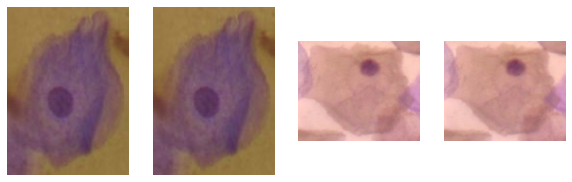

.........................
im_Parabasal


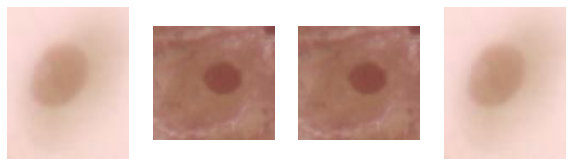

.........................
im_Metaplastic


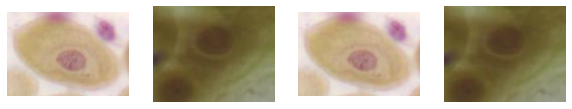

.........................
im_Koilocytotic


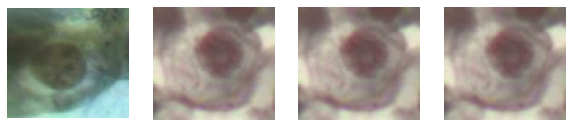

.........................
im_Dyskeratotic


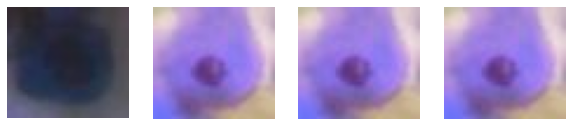

In [309]:
import cv2

# Visualize some training example

label_to_name = {
    0 : 'im_Superficial-Intermediate',
    1 : 'im_Parabasal', 
    2 : 'im_Metaplastic',
    3 : 'im_Koilocytotic',
    4 : 'im_Dyskeratotic'}

for class_ in range(len(label_to_name)):
    print(".........................")
    print(label_to_name[class_])
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 4, 1
    dataset = train_dataset[train_dataset.labels==class_]
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        path, label = dataset[2][sample_idx], dataset[1][sample_idx]
        img = cv2.imread('../data/lab-03-data/part2/'+path)
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

### 2.2 Training (4 points)
In this part your objective is to implement the required tools to train your model. The first thing you'll need is a a model which takes as input the pre-computed features and returns the corresponding class probabilities/logits.

In [310]:
class Net(nn.Module):
    def __init__(self, len_features):
        super().__init__()
        self.fc1 = nn.Linear(len_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)
        self.Softmax = nn.Softmax()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Implement the model
embedding_dim = train_dataset.features.shape[1]
model = Net(embedding_dim)

The optimizer will keep track of your model's parameters, gradients, etc (https://pytorch.org/docs/stable/optim.html). It is responsible to update your model's parameters after each forward pass using the backpropagation algorithm.

In [311]:
# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [312]:
# Set the loss
criterion = nn.CrossEntropyLoss()

Implement a function that takes as input the model's output and the corresponding labels and returns the perçentage of correct predictions.

In [318]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of predictions based on the model outputs (NxK: N samples, K classes) 
    and the labels (N: N samples).
    """
    predictions = torch.argmax(outputs, dim=1)
    accuracy_score(labels, predictions)

Implement a funtion `train` that forwards the complete training set through your model (= 1 epoch) and updates its parameters after each forward pass. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [317]:
def train(model, optimizer, criterion, loader):
    
    # Set the model in train mode
    model.train()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    losses = []
    
    for batch in loader:
        
        # Get the embeddings, labels and paths 
        embeddings = batch[0]
        labels = batch[1]
        paths = batch[2]
        
        # Feed the embeddings to the model
        outputs = model(embeddings)

        # Compute cross entropy loss
        loss = criterion(outputs, labels)
        
        # Reset the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        # Store the outputs, labels and loss
        full_outputs.append(outputs)
        full_labels.append(labels)
        losses.append(loss)
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    
    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    return acc, full_outputs, full_labels, losses

Implement a funtion `validate` that forwards the complete validation or test set through your model and evaluates its predictions. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [315]:
@torch.no_grad()
def validate(model, criterion, loader):
    
    # Set the model in train mode
    model.train()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    full_paths = []
    losses = []
    
    for batch in loader:
        
        # Get the embeddings, labels and paths
        embeddings = batch[0]
        labels = batch[1]
        paths = batch[2]
        
        # Feed the embeddings to the model
        outputs = model(embeddings)

        # Compute cross entropy loss
        loss = criterion(outputs, labels)
        
        # Store the outputs, labels, paths and loss
        full_outputs.append(outputs)
        full_labels.append(labels)
        full_paths.append(paths)
        losses.append(loss)
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    full_paths = np.concatenate(full_paths)
    
    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    return acc, full_outputs, full_labels, losses, full_paths

You should now be able to train you model. Alternate between training and validation steps to find and save the best model (best accuracy on the validation set).

In [319]:
# Main loop
epochs = 5
best_acc = 0
model_savepath = '../data'

for epoch in range(epochs):
    
    # Train
    train_acc, train_full_outputs, train_full_labels, train_losses = train(model, optimizer, criterion, train_loader)

    # Evaluate
    val_acc, val_full_outputs, val_full_labels, val_losses, val_full_paths = validate(model, criterion, val_loader)
    
    # Print results
    print(f"Epoch{epoch}")
    print(f"Train accuracy: {train_acc}")
    print(f"Validation accuracy: {val_acc}")
    
    # Save the model
    if val_acc > best_acc:
        best_acc=val_acc
        torch.save(model.state_dict(), model_savepath+"/model_part2.pt")
        print("Model saved!")

Epoch0
Train accuracy: None
Validation accuracy: None


TypeError: '>' not supported between instances of 'NoneType' and 'int'

### 2.3 Evaluation (4 points)
Re-load the best model and evaluate its predictions on the test set.

In [ ]:
# Re-load the best model
model = model.load_state_dict(torch.load(model_savepath+"/model_part2.pt"))

# Evaluate
test_acc, test_full_outputs, test_full_labels, test_losses, test_full_paths = validate(model, criterion, test_loader)
print("Test accuracy: {}".format(test_acc))

A useful tool to analyze your model's performance on the different classes is the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Computes its entries for your model and the test set.

In [ ]:
from sklearn.metrics import confusion_matrix

# Display the confusion matrix
test_predictions = np.argmax(test_full_outputs, axis=1)
confusion_matrix(test_full_labels, test_predictions)

Alternatively it can be useful to plot the problematic samples as well as the predicted and ground truth classes. Can you do so?

In [ ]:
# Find the misclassified samples
misclassified_samples_paths = test_full_paths[test_full_labels!=test_predictions]
misclassified_samples_pred = test_predictions[test_full_labels!=test_predictions]
misclassified_samples_truth = test_full_labels[test_full_labels!=test_predictions]

# Plot the misclassified samples
for i in range(len(misclassified_samples)):
    img = cv2.imread('../data/lab-03-data/part2/'+misclassified_samples_paths[i])
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title("pred: " + label_to_name[misclassified_samples_pred[i]] + "/ truth: " + label_to_name[misclassified_samples_truth[i]])
    plt.axis("off")
    plt.show()